In [4]:
import nltk
import pandas as pd
import numpy as np
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report

In [5]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# read the dataset
train = pd.read_csv('/kaggle/input/game-reviews/train.csv')
validation = pd.read_csv('/kaggle/input/game-reviews/validation.csv')
test = pd.read_csv('/kaggle/input/game-reviews/test.csv')

In [7]:
train.shape, validation.shape, test.shape

((17877, 5), (3831, 5), (3831, 5))

In [8]:
# view the train data
train.head()

,review_id,title,year,user_review,user_suggestion
0,460,Black Squad,2018.0,"Early Access ReviewVery great shooter, that ha...",1
1,2166,Tree of Savior (English Ver.),2016.0,I love love love playing this game!Super 100%!...,1
2,17242,Eternal Card Game,2016.0,Early Access ReviewAs a fan of MTG and Hearths...,1
3,6959,Tactical Monsters Rumble Arena,2018.0,Turn based strategy game similiar to FF Tactic...,1
4,8807,Yu-Gi-Oh! Duel Links,2017.0,This game has an insanely huge download for be...,0


In [9]:
# view the test data
test.head()

,review_id,title,year,user_review,user_suggestion
0,12053,Infestation: The New Z,2016.0,Unbelievable that this rehash copy and paste t...,0
1,12536,SMITE®,2015.0,I can't recommened this game in its current st...,0
2,747,Heroes & Generals,2016.0,Early Access ReviewThis game is constantly evo...,0
3,3214,World of Warships,2018.0,I play this game because it scratches an itch....,0
4,4036,World of Guns: Gun Disassembly,2016.0,"Finally, a game for people like us to enjoy! P...",1


In [10]:
# view the validation data
validation.head()

,review_id,title,year,user_review,user_suggestion
0,8604,Dungeon Defenders II,2015.0,Early Access Review* Ok Played the first DD lo...,1
1,20407,Minion Masters,2017.0,Product received for freeEarly Access ReviewSo...,1
2,636,Magic Duels,2018.0,Game is extremely unfun to play unless you wan...,0
3,10217,Robocraft,2016.0,Early Access ReviewThis used to be an amazing ...,0
4,9564,Realm of the Mad God,2014.0,"With stunning visuals, an immersive storyline,...",1


In [11]:
train['user_suggestion'].value_counts()

user_suggestion
1    10140
0     7737
Name: count, dtype: int64

In [12]:
test['user_suggestion'].value_counts()

user_suggestion
1    2187
0    1644
Name: count, dtype: int64

In [47]:
# Load the SpaCy English model
# Since we are not using NER, we can disable it to speedup
nlp = spacy.load("en_core_web_sm", disable='ner')

In [48]:
def preprocess_text(texts):
    # lemmatize the tokens and store them in a list
    processed_texts = []
    for doc in nlp.pipe(texts, n_process=-1):
        lemmatized_tokens = [token.lemma_.lower() for token in doc if token.is_alpha and token.lemma_ not in nlp.Defaults.stop_words]
        
        # Join the lemmatized tokens into a string
        processed_text = " ".join(lemmatized_tokens)
        
        processed_texts.append(processed_text)
        
    return processed_texts

In [49]:
# apply preprocess_text function to user_review column
train['user_review'] = preprocess_text(train['user_review'])
validation['user_review'] = preprocess_text(validation['user_review'])
test['user_review'] = preprocess_text(test['user_review'])

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [50]:
#view the first 5 rows
train['user_review'].head()

0    early access reviewvery great shooter original...
1    i love love love play lot class choose bound s...
2    early access reviewas fan mtg hearthstone fun ...
3    turn base strategy game similiar ff tactic day...
4    game insanely huge download phone game blast v...
Name: user_review, dtype: object

In [51]:
count_vectorizer_ohe = CountVectorizer(min_df=0.001, binary=True)

In [52]:
#fit_transform user_review
count_vectorizer_ohe_train = count_vectorizer_ohe.fit_transform(train['user_review'])

In [53]:
# Naive Bayes Classifier
naive_bayes_classifier = BernoulliNB()

In [54]:
#create the naive bayes model for the train data
naive_bayes_classifier.fit(count_vectorizer_ohe_train, train['user_suggestion'])
naive_bayes_classifier.score(count_vectorizer_ohe_train, train['user_suggestion'])

0.8258096996140292

In [55]:
##create the naive bayes model for the validation data
count_vectorizer_ohe_val = count_vectorizer_ohe.transform(validation['user_review'])
naive_bayes_classifier.score(count_vectorizer_ohe_val, validation['user_suggestion'])

0.8120595144870791

In [56]:
# initialize count_vectorizer and name it count_vectorizer
count_vectorizer = CountVectorizer(min_df=0.001)

In [57]:
#fit_transform user_review
count_vectorizer_train = count_vectorizer.fit_transform(train['user_review'])

In [58]:
# Naive Bayes Classifier
naive_bayes_classifier = MultinomialNB()

In [59]:
#create the naive bayes model for the train data
naive_bayes_classifier.fit(count_vectorizer_train, train['user_suggestion'])
naive_bayes_classifier.score(count_vectorizer_train, train['user_suggestion'])

0.8388991441517033

In [60]:
##create the naive bayes model for the validation data
count_vectorizer_val = count_vectorizer.transform(validation['user_review'])
naive_bayes_classifier.score(count_vectorizer_val, validation['user_suggestion'])

0.8258940224484469

In [61]:
# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [62]:
# initialize tfifd vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=0.001)

In [63]:
#create the naive bayes model for the train data using tfidf
tfidf_vectorizer_train = tfidf_vectorizer.fit_transform(train['user_review'])
naive_bayes_classifier.fit(tfidf_vectorizer_train, train['user_suggestion'])
naive_bayes_classifier.score(tfidf_vectorizer_train, train['user_suggestion'])

0.8414722828215024

In [64]:
#create the naive bayes model for the validation data using tfidf
tfidf_vectorizer_val = tfidf_vectorizer.transform(validation['user_review'])
naive_bayes_classifier.score(tfidf_vectorizer_val, validation['user_suggestion'])

0.8209344818585226

In [65]:
tfidf_ngram_vectorizer = TfidfVectorizer(min_df=0.001, ngram_range=(1, 3))

In [66]:
#create the naive bayes model for the train data using tfidf and ngram
tfidf_ngram_vectorizer_train = tfidf_ngram_vectorizer.fit_transform(train['user_review'])
naive_bayes_classifier.fit(tfidf_ngram_vectorizer_train, train['user_suggestion'])
naive_bayes_classifier.score(tfidf_ngram_vectorizer_train, train['user_suggestion'])

0.859204564524249

In [67]:
tfidf_ngram_vectorizer.get_feature_names_out()[150:160]

array(['actually good', 'actually like', 'actually look', 'actually play',
       'actually play game', 'actually pretty', 'actually use',
       'actually want', 'actually work', 'actualy'], dtype=object)

In [68]:
#create the naive bayes model for the validation data using tfidf and ngram
tfidf_ngram_vectorizer_val = tfidf_ngram_vectorizer.transform(validation['user_review'])
naive_bayes_classifier.score(tfidf_ngram_vectorizer_val, validation['user_suggestion'])

0.828765335421561

In [69]:
count_ngram_vectorizer = CountVectorizer(min_df=0.001, ngram_range=(1, 3))

In [70]:
#create the naive bayes model for the train data using count vectorizer and ngram
count_ngram_vectorizer_train = count_ngram_vectorizer.fit_transform(train['user_review'])
naive_bayes_classifier.fit(count_ngram_vectorizer_train, train['user_suggestion'])
naive_bayes_classifier.score(count_ngram_vectorizer_train, train['user_suggestion'])

0.8490238854393914

In [71]:
#create the naive bayes model for the validation data using count vectorizer and ngram
count_ngram_vectorizer_val = count_ngram_vectorizer.transform(validation['user_review'])
naive_bayes_classifier.score(count_ngram_vectorizer_val, validation['user_suggestion'])

0.8258940224484469

In [72]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [73]:
tfidf_ann_vectorizer = TfidfVectorizer(min_df=0.001)

In [74]:
# fitting the ann_vectorizer to the train and validation data
features_train = tfidf_ann_vectorizer.fit_transform(train['user_review'])
features_validation = tfidf_ann_vectorizer.transform(validation['user_review'])

In [75]:
features_test = tfidf_ann_vectorizer.transform(test['user_review'])

In [76]:
# converting the features_train and features_validation 
features_train = torch.tensor(features_train.toarray(), dtype=torch.float32)
features_validation = torch.tensor(features_validation.toarray(), dtype=torch.float32)

In [77]:
features_test = torch.tensor(features_test.toarray(), dtype=torch.float32)

In [78]:
# convert target variables into pytorch tensors
y_train = torch.tensor(train['user_suggestion'])
y_validation = torch.tensor(validation['user_suggestion'])

In [79]:
y_test = torch.tensor(test['user_suggestion'])

In [80]:
# initialise TensorDataset  object
train_dataset = TensorDataset(features_train, y_train)
val_dataset = TensorDataset(features_validation, y_validation)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)

In [81]:
test_dataset = TensorDataset(features_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [82]:
class ANNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
        #self.fc3 = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        #out = self.fc3(out)
        return out

In [83]:
model = ANNModel(input_size=features_train.shape[1], hidden_size=70, output_size=1, dropout_rate=0.5)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [84]:
def calculate_accuracy(loader):
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5  # Apply threshold to convert probabilities to binary predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

Epoch 1/50, Loss: 0.6908, Val Loss: 0.6897
Epoch 2/50, Loss: 0.6884, Val Loss: 0.6869
Epoch 3/50, Loss: 0.6850, Val Loss: 0.6830
Epoch 4/50, Loss: 0.6802, Val Loss: 0.6777
Epoch 5/50, Loss: 0.6743, Val Loss: 0.6719
Epoch 6/50, Loss: 0.6673, Val Loss: 0.6647
Epoch 7/50, Loss: 0.6600, Val Loss: 0.6571
Epoch 8/50, Loss: 0.6520, Val Loss: 0.6495
Epoch 9/50, Loss: 0.6439, Val Loss: 0.6410
Epoch 10/50, Loss: 0.6354, Val Loss: 0.6335
Epoch 11/50, Loss: 0.6266, Val Loss: 0.6252
Epoch 12/50, Loss: 0.6182, Val Loss: 0.6162
Epoch 13/50, Loss: 0.6089, Val Loss: 0.6077
Epoch 14/50, Loss: 0.6002, Val Loss: 0.6006
Epoch 15/50, Loss: 0.5916, Val Loss: 0.5905
Epoch 16/50, Loss: 0.5827, Val Loss: 0.5834
Epoch 17/50, Loss: 0.5739, Val Loss: 0.5743
Epoch 18/50, Loss: 0.5654, Val Loss: 0.5670
Epoch 19/50, Loss: 0.5565, Val Loss: 0.5589
Epoch 20/50, Loss: 0.5477, Val Loss: 0.5513
Epoch 21/50, Loss: 0.5403, Val Loss: 0.5416
Epoch 22/50, Loss: 0.5319, Val Loss: 0.5352
Epoch 23/50, Loss: 0.5235, Val Loss: 0.52

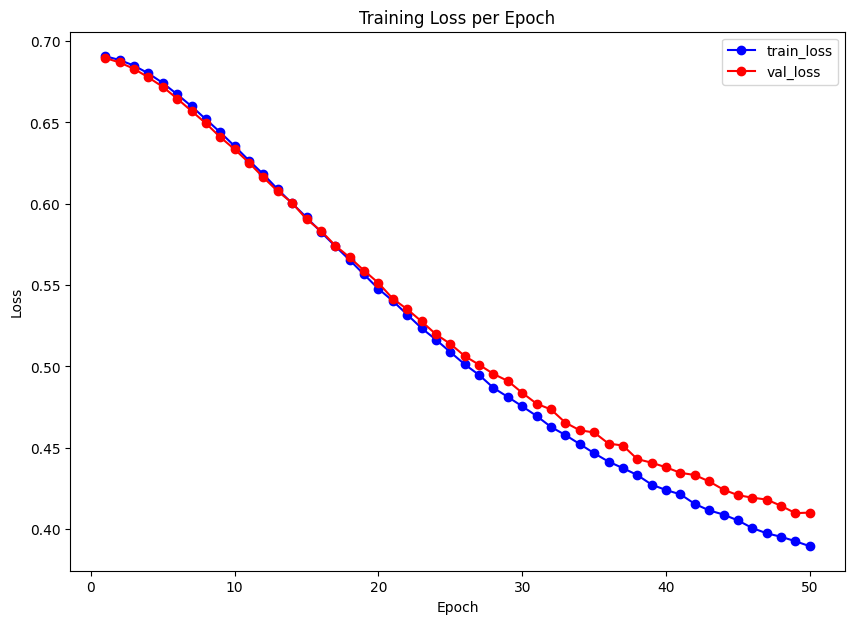

In [85]:
import matplotlib.pyplot as plt

num_epochs = 50  # Number of epochs
losses = []  # List to store the average loss per epoch
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0  # Variable to store the total loss in each epoch
    total_val_loss = 0
    count = 0  # Variable to count the number of batches
    val_count = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()  # Squeeze the output to match the label's shape
        loss = criterion(outputs, labels.float())  # Ensure labels are float
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count  # Calculate average loss for the epoch
    losses.append(average_loss)  # Append average loss to the list
       
    for inputs, labels in val_loader:
        val_outputs = model(inputs)
        val_outputs = val_outputs.squeeze()  # Squeeze the output to match the label's shape
        val_loss = criterion(val_outputs, labels.float())  # Ensure labels are float
        total_val_loss += val_loss.item()
        val_count += 1
    average_val_loss = total_val_loss / val_count  # Calculate average loss for the epoch
    val_losses.append(average_val_loss)  # Append average loss to the list
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')

train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)
print(f'Train Accuracy: {train_accuracy:.4f} Val Accuracy: {val_accuracy:.4f}')

# Plotting the training loss
plt.figure(figsize=(10, 7))
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-', color='b', label = 'train_loss')
plt.plot(range(1, num_epochs + 1), val_losses, marker='o', linestyle='-', color='r', label = 'val_loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [86]:
num_epochs = 20  # Number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()  # Squeeze the output to match the label's shape
        loss = criterion(outputs, labels.float())  # Ensure labels are float
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count  # Calculate average loss for the epoch
    losses.append(average_loss)  # Append average loss to the list
       
    for inputs, labels in val_loader:
        val_outputs = model(inputs)
        val_outputs = val_outputs.squeeze()  # Squeeze the output to match the label's shape
        val_loss = criterion(val_outputs, labels.float())  # Ensure labels are float
        total_val_loss += val_loss.item()
        val_count += 1
    average_val_loss = total_val_loss / val_count  # Calculate average loss for the epoch
    val_losses.append(average_val_loss)  # Append average loss to the list
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')

train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)
print(f'Train Accuracy: {train_accuracy:.4f} Val Accuracy: {val_accuracy:.4f}')

Epoch 1/20, Loss: 0.3874, Val Loss: 0.4081
Epoch 2/20, Loss: 0.3862, Val Loss: 0.4067
Epoch 3/20, Loss: 0.3843, Val Loss: 0.4058
Epoch 4/20, Loss: 0.3830, Val Loss: 0.4048
Epoch 5/20, Loss: 0.3816, Val Loss: 0.4035
Epoch 6/20, Loss: 0.3804, Val Loss: 0.4022
Epoch 7/20, Loss: 0.3791, Val Loss: 0.4012
Epoch 8/20, Loss: 0.3779, Val Loss: 0.4004
Epoch 9/20, Loss: 0.3766, Val Loss: 0.3995
Epoch 10/20, Loss: 0.3754, Val Loss: 0.3987
Epoch 11/20, Loss: 0.3743, Val Loss: 0.3978
Epoch 12/20, Loss: 0.3731, Val Loss: 0.3967
Epoch 13/20, Loss: 0.3719, Val Loss: 0.3959
Epoch 14/20, Loss: 0.3708, Val Loss: 0.3951
Epoch 15/20, Loss: 0.3696, Val Loss: 0.3943
Epoch 16/20, Loss: 0.3685, Val Loss: 0.3934
Epoch 17/20, Loss: 0.3674, Val Loss: 0.3928
Epoch 18/20, Loss: 0.3664, Val Loss: 0.3920
Epoch 19/20, Loss: 0.3653, Val Loss: 0.3914
Epoch 20/20, Loss: 0.3643, Val Loss: 0.3906
Train Accuracy: 85.7359 Val Accuracy: 83.2942


In [87]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
test_count = 0

with torch.inference_mode():
    for inputs, labels in test_loader:
        test_outputs = model(inputs)
        test_outputs = test_outputs.squeeze()  # Squeeze the output to match the label's shape
        loss = criterion(test_outputs, labels.float())  # Ensure labels are float
        test_loss += loss.item()
        test_count += 1

average_test_loss = test_loss / test_count  # Calculate average test loss
test_accuracy = calculate_accuracy(test_loader)
print(f'Test Loss: {average_test_loss:.4f} Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.3780 Test Accuracy: 82.1718
